# Косенко Никита
## Лабораторная работа №2, вариант 9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

Подключаем данные

In [2]:
data = pd.read_csv('data_ml_v2-09.csv')
X = data[['x1', 'x2']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
data

,x1,x2,label
0,2.09900,1.18550,1
1,4.08970,2.34480,1
2,2.29870,1.53440,1
3,2.31340,0.83835,1
4,2.77860,0.52184,1
...,...,...,...
495,0.74488,4.03800,4
496,0.97697,3.33700,4
497,-0.38525,5.38230,4
498,1.28370,2.65840,4


### Задание 1
Оценить ковариационные матрицы обучающих данных для каждого класса при различных предположениях:

a) ковариационные матрицы всех классов равные, скалярные

б) равные, диагональные

в) различные, скалярные

г) различные, диагональные

д) равные

е) различные

Визуализировать матрицы для каждого случая.

In [3]:
# Получаем уникальные классы
classes = np.sort(y_train.unique())
print(classes)

# Инициализируем словарь для хранения ковариационных матриц
cov_matrices = {}

[1 2 3 4]


In [4]:
# a) ковариационные матрицы всех классов равные, скалярные
cov_equal_scalar = np.cov(X_train.T) * np.eye(X_train.shape[1])
cov_matrices['equal, scalar'] = cov_equal_scalar

In [5]:
# б) равные, диагональные
cov_equal_diagonal = np.diag(np.var(X_train, axis=0))
cov_matrices['equal, diagonal'] = cov_equal_diagonal

In [6]:
# в) различные, скалярные
for cls in classes:
    cov_matrices[f'different, scalar, class {cls}'] = np.cov(
        X_train[y_train == cls].T) * np.eye(X_train.shape[1])

In [7]:
# г) различные, диагональные
for cls in classes:
    cov_matrices[f'different, diagonal, class {cls}'] = np.diag(
        np.var(X_train[y_train == cls], axis=0))

In [8]:
# д) равные
cov_equal = np.cov(X_train.T)
cov_matrices['equal'] = cov_equal

In [9]:
# е) различные
for cls in classes:
    cov_matrices[f'different, class {cls}'] = np.cov(X_train[y_train == cls].T)

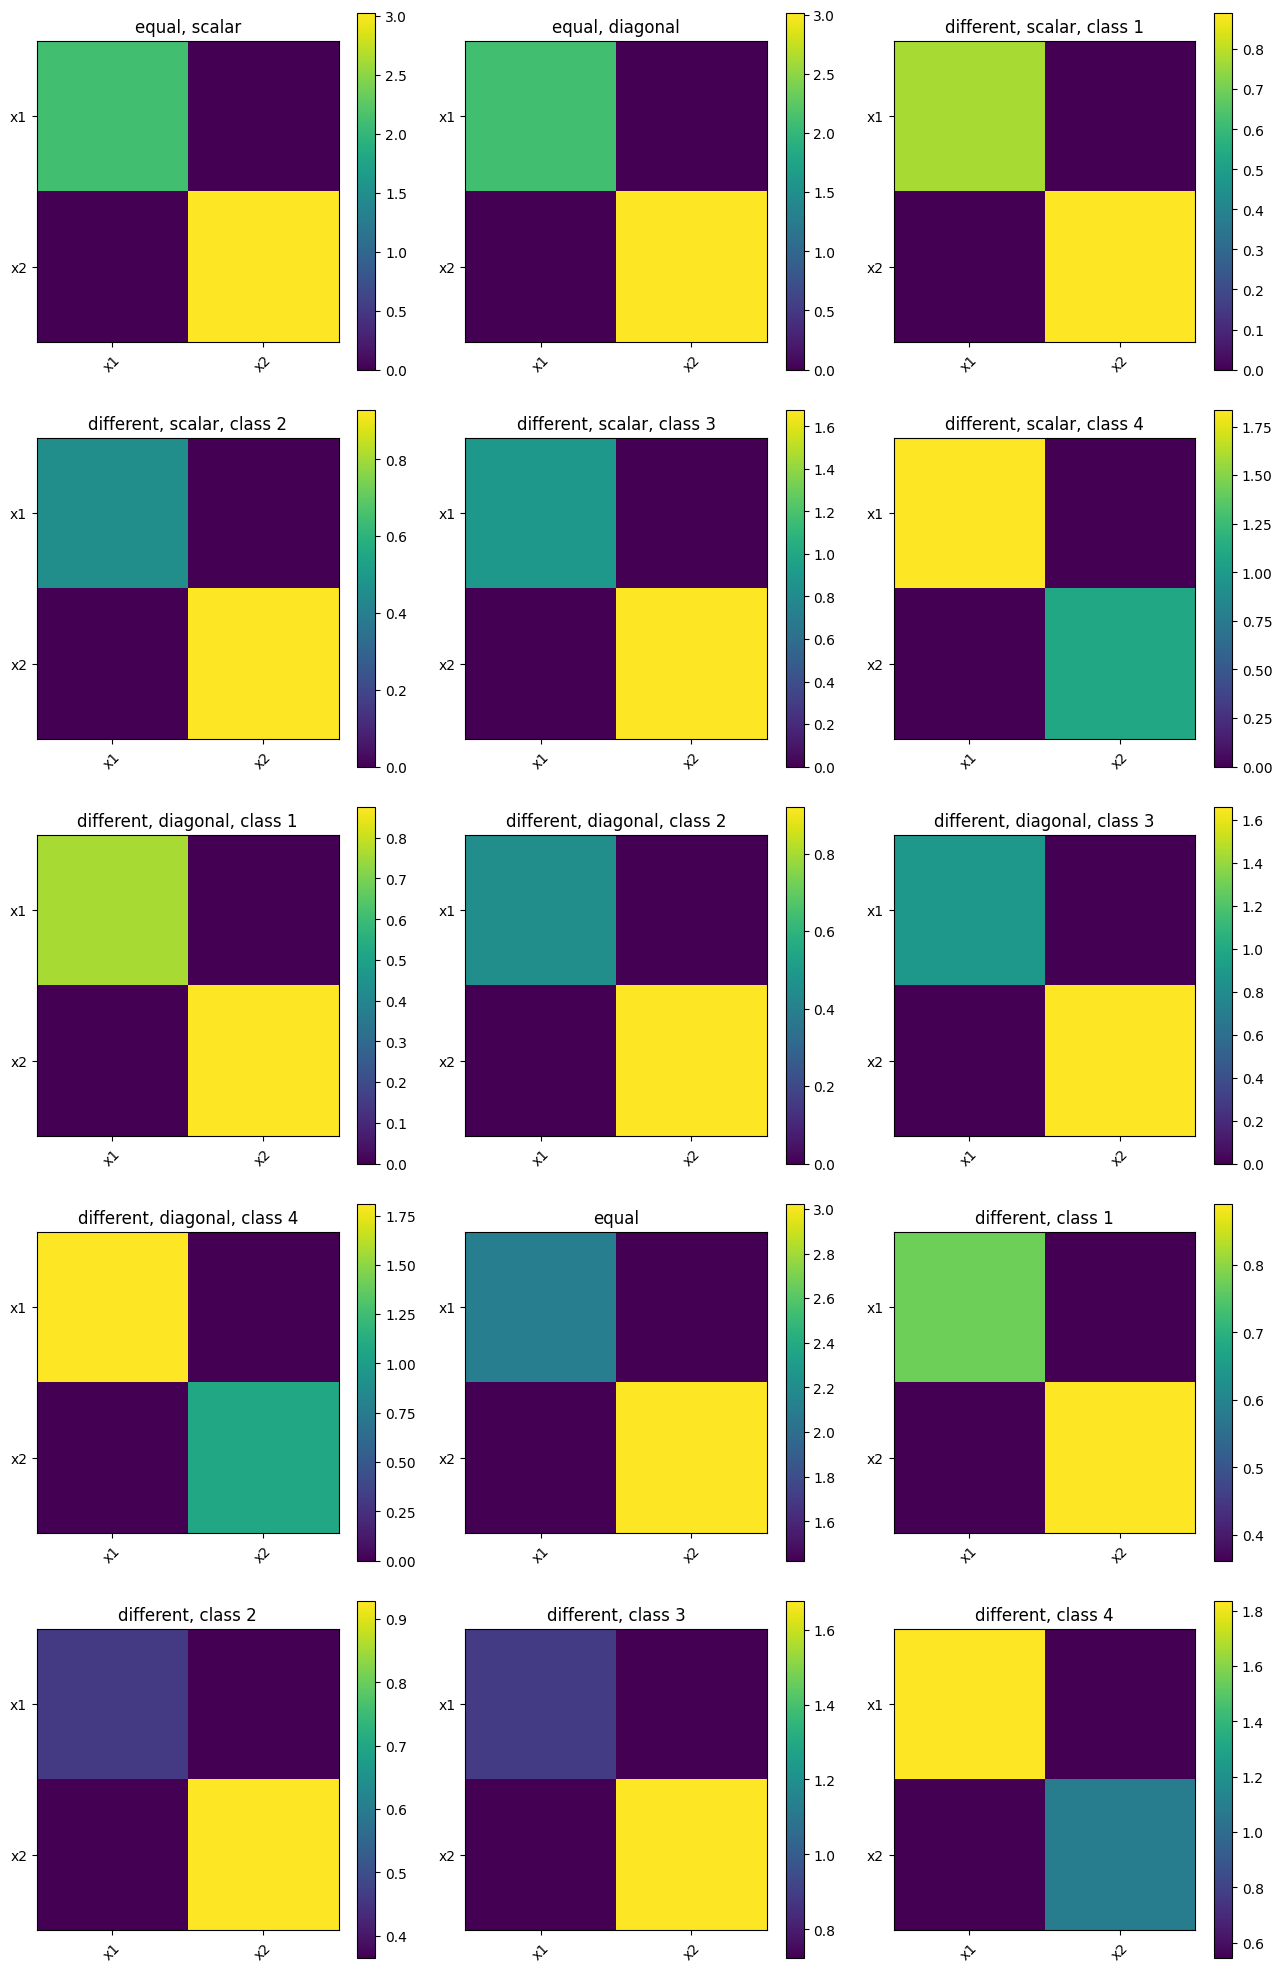

In [10]:
# Визуализация ковариационных матриц
num_matrices = len(cov_matrices)

plt.figure(figsize=(13, 4 * 5))
for i, (key, cov_matrix) in enumerate(cov_matrices.items()):
    plt.subplot(5, 3, i + 1)
    plt.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(key)
    plt.xticks(range(cov_matrix.shape[0]), ['x1', 'x2'], rotation=45)
    plt.yticks(range(cov_matrix.shape[0]), ['x1', 'x2'])

plt.tight_layout()
plt.show()

### Задание 2
Рассчитать классификационные очки байесовских классификаторов, обученных при предположениях а-е пункта 1 для примеров обучающей и тестовой выборок. Априорные вероятности классов считать равными, классификационные очки классификаторов полагать равными апостериорным вероятностям классов.

Реализуем классификатор. Поскольку классов 4, а априорные вероятности считаем равными,то для каждого класса априорная вероятность равна 1/4.
Поскольку классификатор байессовский, теорема Байеса применима:
$$
P(C_k | \mathbf{x}) = \frac{P(\mathbf{x} | C_k) P(C_k)}{P(\mathbf{x})}
$$

Где:
- $ P(C_k | \mathbf{x}) $ — апостериорная вероятность класса $ C_k $ при условии наблюдения $ \mathbf{x} $.
- $ P(\mathbf{x} | C_k) $ — правдоподобие (likelihood) наблюдения $ \mathbf{x} $ при условии класса $ C_k $.
- $ P(C_k) $ — априорная вероятность класса $ C_k $.
- $ P(\mathbf{x}) $ — нормализующая константа, которая может быть вычислена как сумма по всем классам.

#### Нормальный Байесовский Классификатор
Формула для правдоподобия $ P(\mathbf{x} | C_k) $ в нормальном классификаторе выглядит следующим образом:

$$
P(\mathbf{x} | C_k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu_k)^T \Sigma_k^{-1} (\mathbf{x} - \mu_k)\right)
$$

Где:
- $ d $ — количество признаков (размерность).
- $ \mu_k $ — вектор средних значений признаков для класса $ C_k $.
- $ \Sigma_k $ — ковариационная матрица для класса $ C_k $.
- $ | \Sigma_k | $ — определитель ковариационной матрицы.
- $ \Sigma_{k}^{-1} $ — обратная ковариационная матрица.

---

#### Общая Формула для Классификации

Для классификации, мы выбираем класс $ C_k $, который максимизирует апостериорную вероятность:

$$
\hat{C} = \arg\max_{C_k} P(C_k | \mathbf{x}) = \arg\max_{C_k} P(\mathbf{x} | C_k) P(C_k)
$$

In [11]:
class NormalBayesClassifier:
    def __init__(self, covariances: dict):
        self.means = {}
        self.priors = {}
        self.classes = None
        self.covariances = covariances

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = X_cls.mean(axis=0)
            self.priors[cls] = 0.25

    def predict_all(self, X):  # predict all the observations
        predicts = []
        classes = []
        for x in zip(X['x1'], X['x2']):
            p, c = self.predict(x)
            predicts.append(p)
            classes.append(c)
        return predicts, classes

    def predict(self, x):  # predict the class and posteriors of one observation
        posteriors = []
        en = {}
        if len(self.covariances) == 1:
            en[1] = list(self.covariances.values())[0]
            en[2] = list(self.covariances.values())[0]
            en[3] = list(self.covariances.values())[0]
            en[4] = list(self.covariances.values())[0]
        else:
            en[1] = list(self.covariances.values())[0]
            en[2] = list(self.covariances.values())[1]
            en[3] = list(self.covariances.values())[2]
            en[4] = list(self.covariances.values())[3]
        for cls in self.classes:
            prior = self.priors[cls]
            likelihood = self._multivariate_gaussian(
                x, self.means[cls], en[cls])
            posterior = prior * likelihood
            posteriors.append(posterior)

        return posteriors, self.classes[np.argmax(posteriors, axis=0)]

    def _multivariate_gaussian(self, x, mean, cov):
        d = 2  # number of features
        cov_inv = np.linalg.inv(cov)  # dimention is 2 × 2
        norm_const = 1 / (2 * np.pi)**(d/2) * np.sqrt(np.linalg.det(cov))
        centered = x - mean  # dimention is 2 × 1
        # for transposed centered dimention is 1 × 2
        i = np.dot(centered.T, cov_inv)
        p = np.exp(-0.5 * np.dot(i, centered))
        return norm_const * p

Получение классификационных очков

In [12]:
classifiers = {}

# Обрабатываем каждый ключ в словаре
for key, covariance_matrix in cov_matrices.items():
    # Проверяем, содержит ли ключ информацию о классе
    if 'equal' in key:
        print(key)
        print(covariance_matrix)
        classifiers[key] = NormalBayesClassifier({key: covariance_matrix})

equal, scalar
[[2.10596526 0.        ]
 [0.         3.02134624]]
equal, diagonal
[[2.09994822 0.        ]
 [0.         3.01271382]]
equal
[[2.10596526 1.4234575 ]
 [1.4234575  3.02134624]]


In [13]:
different_scalar_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, scalar' in key:
        different_scalar_matrices[key] = covariance_matrix

for key, covariance_matrix in different_scalar_matrices.items():
    print(key)
    print(covariance_matrix)
    print()

different_scalar_classifier = {
    'different, scalar': NormalBayesClassifier(different_scalar_matrices)}

different, scalar, class 1
[[0.77243985 0.        ]
 [0.         0.88961723]]

different, scalar, class 2
[[0.46027404 0.        ]
 [0.         0.92787436]]

different, scalar, class 3
[[0.89316253 0.        ]
 [0.         1.67556938]]

different, scalar, class 4
[[1.83445247 0.        ]
 [0.         1.09390425]]



In [14]:
different_diagonal_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, diagonal' in key:
        different_diagonal_matrices[key] = covariance_matrix

for key, covariance_matrix in different_diagonal_matrices.items():
    print(key)
    print(covariance_matrix)
    print()

different_diagonal_classifier = {
    'different, diagonal': NormalBayesClassifier(different_diagonal_matrices)}

different, diagonal, class 1
[[0.7597769  0.        ]
 [0.         0.87503334]]

different, diagonal, class 2
[[0.45620082 0.        ]
 [0.         0.91966308]]

different, diagonal, class 3
[[0.88481521 0.        ]
 [0.         1.65990985]]

different, diagonal, class 4
[[1.8078662  0.        ]
 [0.         1.07805056]]



In [15]:

different_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, class' in key:
        different_matrices[key] = covariance_matrix

for key, covariance_matrix in different_matrices.items():
    print(key)
    print(covariance_matrix)
    print()

different_classifier = {'different': NormalBayesClassifier(different_matrices)}

different, class 1
[[0.77243985 0.36216326]
 [0.36216326 0.88961723]]

different, class 2
[[0.46027404 0.36536996]
 [0.36536996 0.92787436]]

different, class 3
[[0.89316253 0.72492403]
 [0.72492403 1.67556938]]

different, class 4
[[1.83445247 0.54609578]
 [0.54609578 1.09390425]]



In [16]:
classifiers.update(different_scalar_classifier)
classifiers.update(different_diagonal_classifier)
classifiers.update(different_classifier)

for name, classifier in classifiers.items():
    print(f"Classifier: {name}")

Classifier: equal, scalar
Classifier: equal, diagonal
Classifier: equal
Classifier: different, scalar
Classifier: different, diagonal
Classifier: different


In [17]:
# Получение классификационных очков на обучающей выборке

train_scores = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    scores, _ = clf.predict_all(X_train)  # Получаем предсказания
    train_scores[name] = scores

# Получение классификационных очков на тестовой выборке
test_scores = {}
for name, clf in classifiers.items():
    fitted = clf.fit(X_test, y_test)
    scores, _ = clf.predict_all(X_test)  # Получаем предсказания
    test_scores[name] = scores

# Выводим классификационные очки
print("Train Scores:")
for name, scores in train_scores.items():
    print(f"{name}: {scores}")

print("\nTest Scores:")
for name, scores in test_scores.items():
    print(f"{name}: {scores}")

Train Scores:
equal, scalar: [[np.float64(0.0392635660953009), np.float64(0.04014496283996464), np.float64(0.08191080777412162), np.float64(0.036796948481658785)], [np.float64(0.02025664157800342), np.float64(0.06428513985971296), np.float64(0.07816619043544508), np.float64(0.03966293731421697)], [np.float64(0.09744344005394895), np.float64(0.0014567632974356837), np.float64(0.03525293527905489), np.float64(0.02192938393768359)], [np.float64(0.09235128868016297), np.float64(0.0008533604249594867), np.float64(0.027416831331033644), np.float64(0.017744270499798487)], [np.float64(0.002878252048040734), np.float64(0.07682845823348489), np.float64(0.03928160970989988), np.float64(0.029225952678872007)], [np.float64(0.05243285661735492), np.float64(0.01437894122556327), np.float64(0.0936882235361984), np.float64(0.08170943687586192)], [np.float64(0.09579693111425658), np.float64(0.003196557660401691), np.float64(0.03901307209382562), np.float64(0.016756151864891003)], [np.float64(0.003442239

### Задание 3
В исходном пространстве признаков изобразить области классов (закрасить разными цветами), формируемые каждым из обученных классификаторов. Нанести на диаграммы границы классов и данные из обучающей и тестовой выборок. На отдельной диаграмме изобразить все границы классов, формируемые построенными классификаторами.

2


/tmp/ipykernel_37394/1268534156.py:30: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['x1'], X_test['x2'], c='red',


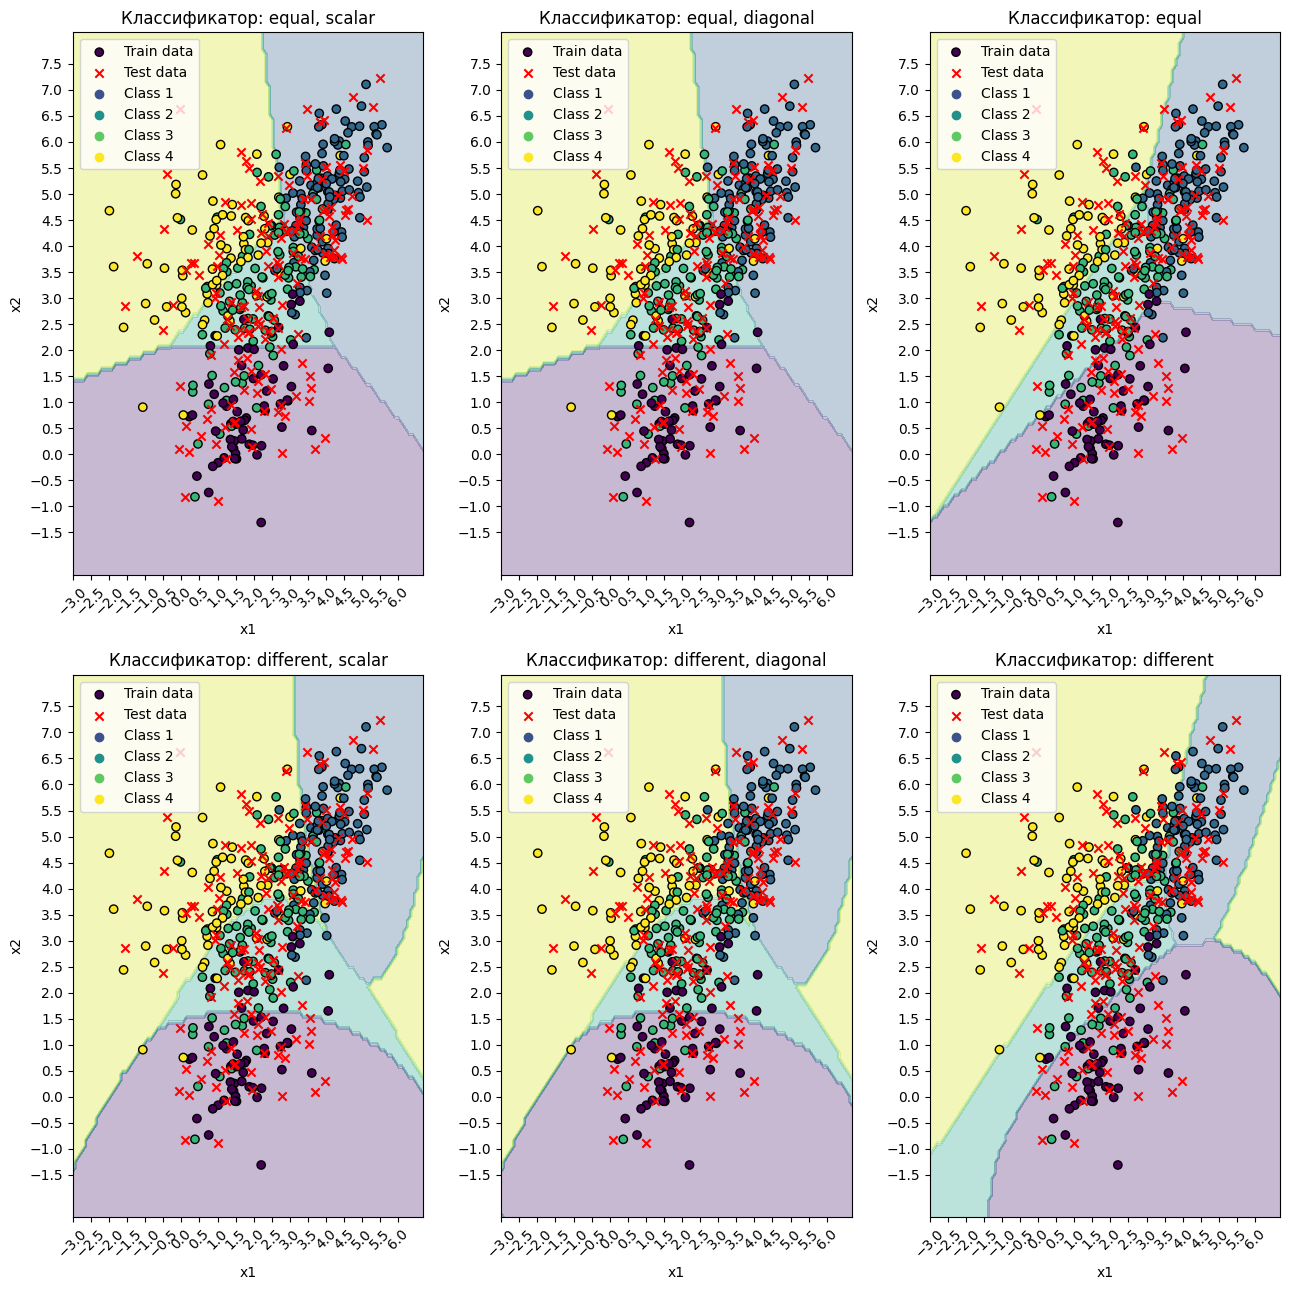

In [18]:
# # Создаем сетку для предсказаний
x1_range = np.linspace(X_train['x1'].min() - 1, X_train['x1'].max() + 1, 100)
x2_range = np.linspace(X_train['x2'].min() - 1, X_train['x2'].max() + 1, 100)
xx, yy = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Визуализация
plt.figure(figsize=(13, 13))

num_classifiers = len(classifiers)
rows = (num_classifiers // 3) + (num_classifiers %
                                 3 > 0)  # Определяем количество строк

print(rows)

for idx, (name, clf) in enumerate(classifiers.items()):
    # Получаем предсказания для сетки
    grid_predictions, _ = clf.predict_all(
        pd.DataFrame(grid_points, columns=['x1', 'x2']))
    grid_predictions = np.array(grid_predictions)

    # Преобразуем предсказания в форму сетки
    Z = np.array([np.argmax(pred)
                 for pred in grid_predictions]).reshape(xx.shape)

    plt.subplot(rows, 3, idx + 1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X_train['x1'], X_train['x2'], c=y_train,
                edgecolor='k', marker='o', label='Train data')
    plt.scatter(X_test['x1'], X_test['x2'], c='red',
                edgecolor='k', marker='x', label='Test data')
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        plt.scatter([], [], label=f'Class {cls}',
                    color=plt.cm.viridis(cls / len(unique_classes)))
    plt.title(f'Классификатор: {name}')
    plt.xlabel('x1')
    plt.xticks(np.arange(-3, 6.5, 0.5), rotation=45)
    plt.ylabel('x2')
    plt.yticks(np.arange(-1.5, 8, 0.5))
    # plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_37394/1459815232.py:18: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['x1'], X_test['x2'], c='red',


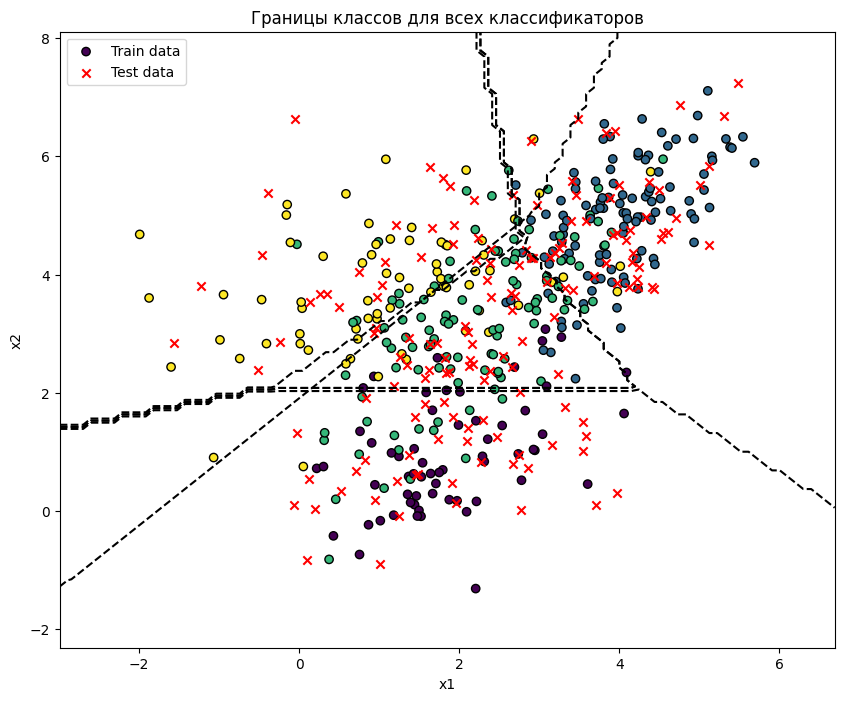

In [19]:

# Общая визуализация для всех классификаторов
plt.figure(figsize=(10, 8))
for idx, (name, clf) in enumerate(classifiers.items()):
    # Получаем предсказания для сетки
    grid_predictions, _ = clf.predict_all(
        pd.DataFrame(grid_points, columns=['x1', 'x2']))
    grid_predictions = np.array(grid_predictions)

    # Преобразуем предсказания в форму сетки
    Z = np.array([np.argmax(pred)
                 for pred in grid_predictions]).reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0.5 + idx,
                1.5 + idx], colors='k', linestyles='--')

plt.scatter(X_train['x1'], X_train['x2'], c=y_train,
            edgecolor='k', marker='o', label='Train data')
plt.scatter(X_test['x1'], X_test['x2'], c='red',
            edgecolor='k', marker='x', label='Test data')
plt.title('Границы классов для всех классификаторов')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

### Задание 4
Рассчитать точности (accuracy) построенных классификаторов на обучающей и тестовой выборках, представить данные в графическом виде (bar charts).

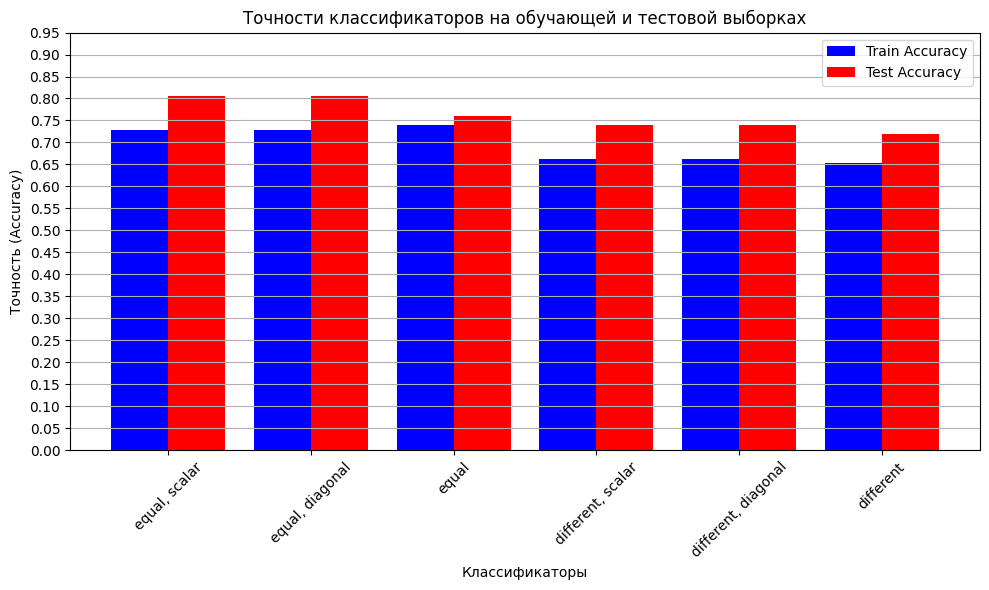

In [20]:
# Словари для хранения точностей
train_accuracies = {}
test_accuracies = {}

# Рассчитываем точности для каждого классификатора
for name, clf in classifiers.items():
    _, train_predictions = clf.predict_all(X_train)
    _, test_predictions = clf.predict_all(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    train_accuracies[name] = train_accuracy
    test_accuracies[name] = test_accuracy

labels = list(train_accuracies.keys())
train_values = list(train_accuracies.values())
test_values = list(test_accuracies.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, train_values, width=0.4,
        label='Train Accuracy', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_values, width=0.4,
        label='Test Accuracy', color='r', align='center')

plt.xlabel('Классификаторы')
plt.ylabel('Точность (Accuracy)')
plt.title('Точности классификаторов на обучающей и тестовой выборках')
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks([p + 0.2 for p in x], labels, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

### Задание 5
Для каждого классификатора построить:
1. micro-averaged ROC-кривые
2. micro-averaged PR-кривые
3. рассчитать micro-averaged ROC AUC и PR AUC
4. macro-averaged ROC-кривые
5. macro-averaged PR-кривые
6. рассчитать macro-averaged ROC AUC и PR AUC

на обучающей и тестовой выборках.

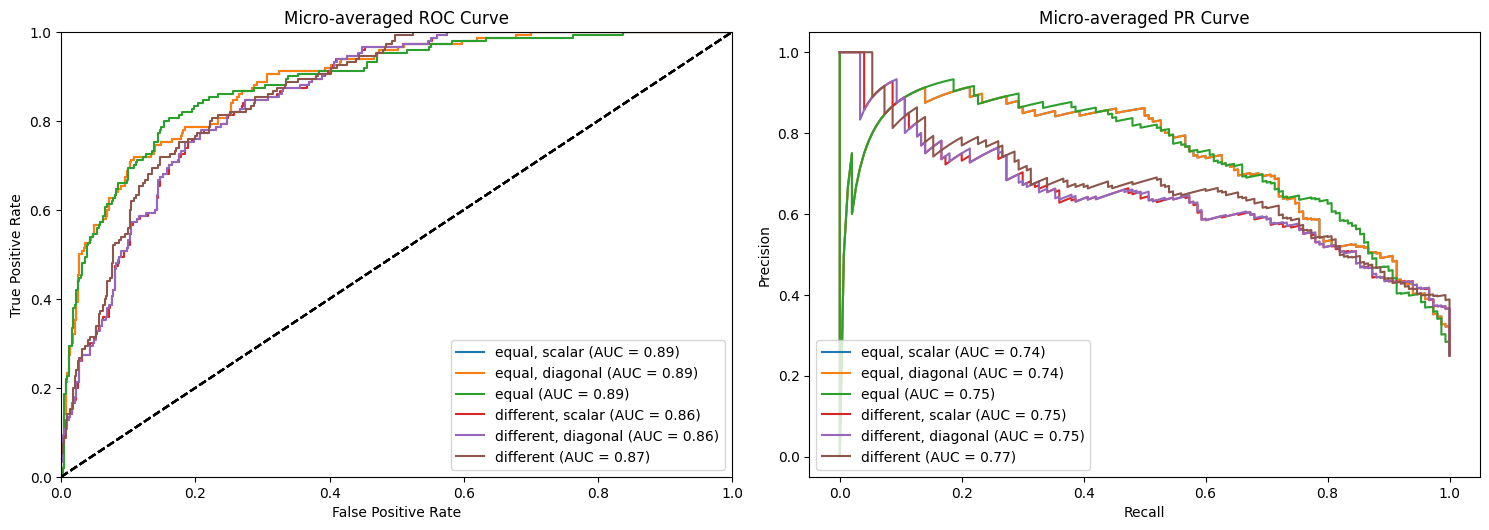

In [23]:
# Функция для построения ROC и PR кривых
def plot_roc_pr_curves(classifiers, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(15, 10))

    # Micro-averaged ROC and PR curves
    for name, clf in classifiers.items():
        # Получаем вероятности для тестовой выборки
        test_predictions, _ = clf.predict_all(X_test)

        # Бинаризация меток
        y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
        y_score = np.array([pred for pred in test_predictions])

        # ROC
        fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)

        # PR
        precision, recall, _ = precision_recall_curve(y_test_binarized.ravel(), y_score.ravel())
        pr_auc = average_precision_score(y_test_binarized, y_score)

        # Plot ROC curve
        plt.subplot(2, 2, 1)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Micro-averaged ROC Curve')
        plt.legend(loc='lower right')

        # Plot PR curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Micro-averaged PR Curve')
        plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

# Вызываем функцию для построения кривых
plot_roc_pr_curves(classifiers, X_train, y_train, X_test, y_test)

### Задание 6
Сделать выводы о влиянии предположений о модели обучающих данных на точность байесовской классификации.